# DAX Direction Given Volatility Regime Change
## Does Direction Persistence Change When Volatility Regime Shifts?

**Objective:** Test whether directional persistence (P(continuation)) changes depending on volatility regime transitions (stable, rising, falling).

**Key Questions:**
- When volatility RISES (Low→High, Low→Normal): Does direction tend to continue or flip?
- When volatility FALLS (High→Low, High→Normal): Are reversals more common?
- When volatility STAYS SAME (Low→Low, Normal→Normal, High→High): What's the baseline persistence?

**Hypothesis:**
- H0: Direction continuation is independent of volatility regime transitions (no interaction)
- H1: Regime transitions affect direction persistence (interactions exist)

**Data:** M5 OHLCV bars, Jan 2023 – Sept 2025, UTC → Berlin time (pytz auto DST), RTH only (09:00-17:30)

**Critical Constraint:** All regime transitions use only past data (no look-ahead bias).

---


## Part 1: Data Preparation and Daily Metrics


In [11]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 1: Fetch Data and Calculate Daily Metrics


In [12]:
print('\n[STEP 1] Fetch M5 Data and Aggregate to Daily')
print('='*80)

# Get available date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = end_date - timedelta(days=730)

print(f'Fetching M5 data: {start_date.date()} to {end_date.date()}')

# Fetch M5 data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'[OK] Fetched {len(df)} M5 candles')

# Extract time components
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Filter to RTH
df_rth = df[(df['hour'] >= 9) & ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))].copy()

print(f'[OK] Filtered to RTH (09:00-17:30): {len(df_rth)} candles')

# Calculate True Range
df_rth['c_prev'] = df_rth['close'].shift(1)
day_boundary = df_rth['date'] != df_rth['date'].shift(1)
df_rth.loc[day_boundary, 'c_prev'] = np.nan

df_rth['hl_range'] = df_rth['high'] - df_rth['low']
df_rth['h_cp_range'] = (df_rth['high'] - df_rth['c_prev']).abs()
df_rth['l_cp_range'] = (df_rth['low'] - df_rth['c_prev']).abs()
df_rth['tr'] = df_rth[['hl_range', 'h_cp_range', 'l_cp_range']].max(axis=1)
df_rth.loc[day_boundary, 'tr'] = df_rth.loc[day_boundary, 'hl_range']

print(f'[OK] Calculated True Range for all M5 bars')


[STEP 1] Fetch M5 Data and Aggregate to Daily


2025-11-29 15:51:56,085 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2023-01-08 23:00:00+00:00 to 2025-09-16 21:55:00+00:00
2025-11-29 15:51:56,086 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2023-09-17 21:55:00+00:00, end=2025-09-16 21:55:00+00:00


Fetching M5 data: 2023-09-17 to 2025-09-16


2025-11-29 15:51:58,333 - shared.database_connector - INFO - [OK] Fetched 136661 candles (2023-09-17 21:55:00+00:00 to 2025-09-16 21:55:00+00:00)


[OK] Fetched 136661 M5 candles
[OK] Filtered to RTH (09:00-17:30): 53005 candles
[OK] Calculated True Range for all M5 bars


## Step 2: Aggregate to Daily and Assign Regimes (No Look-Ahead)


In [13]:
print('\n[STEP 2] Aggregate to Daily Level and Assign Regimes')
print('='*80)

daily_data = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 12:
        continue
    
    daily_open = day_data.iloc[0]['open']
    daily_close = day_data.iloc[-1]['close']
    daily_tr_sum = day_data['tr'].sum()
    atrp = (daily_tr_sum / daily_close) * 100 if daily_close > 0 else 0
    
    daily_return = (daily_close / daily_open - 1) * 100 if daily_open > 0 else 0
    
    row = {
        'date': date,
        'daily_open': daily_open,
        'daily_close': daily_close,
        'daily_return': daily_return,
        'daily_tr_sum': daily_tr_sum,
        'atrp': atrp,
        'n_bars': len(day_data),
    }
    daily_data.append(row)

df_daily = pd.DataFrame(daily_data).sort_values('date').reset_index(drop=True)

print(f'[OK] Aggregated to {len(df_daily)} trading days')

# Volatility regime labeling (no look-ahead)
def rolling_percentile_rank(series, window=61):
    """Calculate percentile rank with no look-ahead bias."""
    ranks = []
    for i in range(len(series)):
        if i < window - 1:
            ranks.append(np.nan)
        else:
            prior_window = series.iloc[i - window + 1: i].values
            current_value = series.iloc[i]
            rank = stats.percentileofscore(prior_window, current_value)
            ranks.append(rank)
    return ranks

df_daily['atrp_percentile_rank'] = rolling_percentile_rank(df_daily['atrp'], window=61)

def label_regime(percentile):
    if pd.isna(percentile):
        return 'Unknown'
    elif percentile < 33.33:
        return 'Low'
    elif percentile < 66.67:
        return 'Normal'
    else:
        return 'High'

df_daily['regime'] = df_daily['atrp_percentile_rank'].apply(label_regime)

# Filter to valid regimes
df_daily_valid = df_daily[df_daily['regime'] != 'Unknown'].reset_index(drop=True)

print(f'[OK] Assigned regimes (60-day rolling percentile, no look-ahead)')
print(f'Valid regime days: {len(df_daily_valid)}')

print(f'\nRegime Distribution:')
for regime in ['Low', 'Normal', 'High']:
    count = (df_daily_valid['regime'] == regime).sum()
    pct = count / len(df_daily_valid) * 100
    print(f'  {regime:8} {count:4d} days ({pct:5.1f}%)')


[STEP 2] Aggregate to Daily Level and Assign Regimes
[OK] Aggregated to 515 trading days
[OK] Assigned regimes (60-day rolling percentile, no look-ahead)
Valid regime days: 455

Regime Distribution:
  Low       167 days ( 36.7%)
  Normal    141 days ( 31.0%)
  High      147 days ( 32.3%)


## Step 3: Direction and Regime Transitions


In [14]:
print('\n[STEP 3] Direction Classification and Regime Transitions')
print('='*80)

# Direction
df_daily_valid['direction'] = np.sign(df_daily_valid['daily_return'])
df_daily_valid['direction'] = df_daily_valid['direction'].replace(0, np.nan)

# Forward-looking pairs
df_daily_valid['direction_next'] = df_daily_valid['direction'].shift(-1)
df_daily_valid['regime_next'] = df_daily_valid['regime'].shift(-1)

# Drop last day
df_pairs = df_daily_valid[df_daily_valid['direction_next'].notna()].copy()
df_pairs = df_pairs[df_pairs['direction'].notna()].copy()

df_pairs['return_next'] = df_pairs['daily_return'].shift(-1)



print(f'[OK] Created {len(df_pairs)} day pairs')

# Classify regime transitions
def classify_regime_transition(regime_today, regime_tomorrow):
    """Classify regime transition type."""
    regime_order = {'Low': 0, 'Normal': 1, 'High': 2}
    
    today_val = regime_order.get(regime_today, -1)
    tomorrow_val = regime_order.get(regime_tomorrow, -1)
    
    if today_val == tomorrow_val:
        return 'Stable'
    elif tomorrow_val > today_val:
        diff = tomorrow_val - today_val
        if diff == 1:
            return 'Up_1step'
        else:
            return 'Up_2step'
    else:  # tomorrow_val < today_val
        diff = today_val - tomorrow_val
        if diff == 1:
            return 'Down_1step'
        else:
            return 'Down_2step'

df_pairs['regime_transition'] = df_pairs.apply(
    lambda row: classify_regime_transition(row['regime'], row['regime_next']),
    axis=1
)

print(f'\nRegime Transition Distribution:')
for transition_type in ['Stable', 'Up_1step', 'Up_2step', 'Down_1step', 'Down_2step']:
    count = (df_pairs['regime_transition'] == transition_type).sum()
    if count > 0:
        pct = count / len(df_pairs) * 100
        print(f'  {transition_type:12} {count:4d} days ({pct:5.1f}%)')

# Define continuation
df_pairs['is_continuation'] = (df_pairs['direction'] == df_pairs['direction_next']).astype(int)


[STEP 3] Direction Classification and Regime Transitions
[OK] Created 454 day pairs

Regime Transition Distribution:
  Stable        242 days ( 53.3%)
  Up_1step       78 days ( 17.2%)
  Up_2step       23 days (  5.1%)
  Down_1step    100 days ( 22.0%)
  Down_2step     11 days (  2.4%)


## Step 4: Directional Persistence by Regime Transition Type


In [15]:
print('\n[STEP 4] Directional Persistence by Regime Transition Type')
print('='*80)

results_by_transition = []

print(f'\n{"Regime Transition":<18} {"N Days":>8} {"P(Cont)":>10} {"Mean Return":>12} {"Sig?":>6}')
print('='*60)

for transition_type in ['Stable', 'Up_1step', 'Up_2step', 'Down_1step', 'Down_2step']:
    subset = df_pairs[df_pairs['regime_transition'] == transition_type]
    
    if len(subset) < 5:
        print(f'{transition_type:<18} {len(subset):>8d} {"N/A":>10} {"N/A":>12} {"N/A":>6}')
        continue
    
    n = len(subset)
    cont = subset['is_continuation'].sum()
    p_cont = cont / n
    mean_return = subset['return_next'].mean()
    
    # Binomial test
    binom_result = stats.binomtest(cont, n, 0.5, alternative='two-sided')
    is_sig = 'YES' if binom_result.pvalue < 0.05 else 'NO'
    
    print(f'{transition_type:<18} {n:>8d} {p_cont:>9.0%}  {mean_return:>+11.3f}% {is_sig:>6}')
    
    results_by_transition.append({
        'transition_type': transition_type,
        'n': n,
        'p_continuation': p_cont,
        'mean_return_next': mean_return,
        'p_value': binom_result.pvalue,
        'is_significant': binom_result.pvalue < 0.05,
    })

df_results_transitions = pd.DataFrame(results_by_transition)

print(f'\n[KEY INSIGHT]')
print(f'Compare P(Cont) across transition types:')
print(f'- Stable regimes: Do they show higher persistence?')
print(f'- Rising volatility: Does continuation drop?')
print(f'- Falling volatility: Do reversals increase?')


[STEP 4] Directional Persistence by Regime Transition Type

Regime Transition    N Days    P(Cont)  Mean Return   Sig?
Stable                  242       50%       +0.047%     NO
Up_1step                 78       51%       -0.012%     NO
Up_2step                 23       48%       -0.782%     NO
Down_1step              100       51%       +0.202%     NO
Down_2step               11       27%       +0.006%     NO

[KEY INSIGHT]
Compare P(Cont) across transition types:
- Stable regimes: Do they show higher persistence?
- Rising volatility: Does continuation drop?
- Falling volatility: Do reversals increase?


## Step 5: Detailed Breakdown by Regime and Transition


In [16]:
print('\n[STEP 5] Detailed Analysis: Direction Persistence by Regime + Transition')
print('='*80)

# Analysis grouped by TODAY's regime AND transition type
analysis_data = []

for regime in ['Low', 'Normal', 'High']:
    regime_subset = df_pairs[df_pairs['regime'] == regime]
    
    if len(regime_subset) == 0:
        continue
    
    print(f'\n\n{regime.upper()} VOLATILITY REGIME TODAY:')
    print('-' * 90)
    
    for transition_type in ['Stable', 'Up_1step', 'Down_1step']:
        subset = regime_subset[regime_subset['regime_transition'] == transition_type]
        
        if len(subset) < 5:
            continue
        
        n = len(subset)
        cont = subset['is_continuation'].sum()
        p_cont = cont / n
        mean_return = subset['return_next'].mean()
        
        # Direction breakdown
        up_days = (subset['direction'] > 0).sum()
        down_days = (subset['direction'] < 0).sum()
        
        print(f'\n  Transition: {transition_type:12} (n={n})')
        print(f'    P(Continuation) = {p_cont:.1%}')
        print(f'    Mean return next day = {mean_return:+.3f}%')
        print(f'    Up days: {up_days}, Down days: {down_days}')
        
        analysis_data.append({
            'regime_today': regime,
            'transition_type': transition_type,
            'n': n,
            'p_continuation': p_cont,
            'mean_return_next': mean_return,
        })


[STEP 5] Detailed Analysis: Direction Persistence by Regime + Transition


LOW VOLATILITY REGIME TODAY:
------------------------------------------------------------------------------------------

  Transition: Stable       (n=100)
    P(Continuation) = 52.0%
    Mean return next day = +0.133%
    Up days: 67, Down days: 33

  Transition: Up_1step     (n=44)
    P(Continuation) = 52.3%
    Mean return next day = +0.085%
    Up days: 27, Down days: 17


NORMAL VOLATILITY REGIME TODAY:
------------------------------------------------------------------------------------------

  Transition: Stable       (n=52)
    P(Continuation) = 38.5%
    Mean return next day = +0.001%
    Up days: 29, Down days: 23

  Transition: Up_1step     (n=34)
    P(Continuation) = 50.0%
    Mean return next day = -0.138%
    Up days: 21, Down days: 13

  Transition: Down_1step   (n=55)
    P(Continuation) = 60.0%
    Mean return next day = +0.175%
    Up days: 34, Down days: 21


HIGH VOLATILITY REGIME TODAY:
-

## Step 6: Key Comparisons


In [17]:
print('\n[STEP 6] Key Comparisons and Patterns')
print('='*80)

if len(df_results_transitions) > 0:
    # Compare stable vs non-stable
    stable_data = df_results_transitions[df_results_transitions['transition_type'] == 'Stable']
    non_stable_data = df_results_transitions[df_results_transitions['transition_type'] != 'Stable']
    
    if len(stable_data) > 0 and len(non_stable_data) > 0:
        stable_p_cont = stable_data.iloc[0]['p_continuation']
        non_stable_p_cont = non_stable_data['p_continuation'].mean()
        
        print(f'\n[COMPARISON 1: Stable vs Changing Regimes]')
        print(f'Stable (same regime tomorrow):     P(Cont) = {stable_p_cont:.1%}')
        print(f'Changing (regime shift tomorrow):  P(Cont) = {non_stable_p_cont:.1%}')
        print(f'Difference: {abs(stable_p_cont - non_stable_p_cont):+.1%}')
        
        if stable_p_cont > non_stable_p_cont:
            print(f'→ FINDING: Stable regimes → higher continuation (direction persists more)')
        elif stable_p_cont < non_stable_p_cont:
            print(f'→ FINDING: Changing regimes → higher continuation (opposite expected)')
        else:
            print(f'→ FINDING: No difference (regime stability irrelevant to direction)')
    
    # Compare rising vs falling
    rising = df_results_transitions[df_results_transitions['transition_type'].str.startswith('Up')]
    falling = df_results_transitions[df_results_transitions['transition_type'].str.startswith('Down')]
    
    if len(rising) > 0 and len(falling) > 0:
        rising_p_cont = rising['p_continuation'].mean()
        falling_p_cont = falling['p_continuation'].mean()
        
        print(f'\n[COMPARISON 2: Rising vs Falling Volatility]')
        print(f'Rising volatility (Low→Normal, Low→High, etc): P(Cont) = {rising_p_cont:.1%}')
        print(f'Falling volatility (High→Low, High→Normal, etc): P(Cont) = {falling_p_cont:.1%}')
        print(f'Difference: {abs(rising_p_cont - falling_p_cont):+.1%}')
        
        if rising_p_cont > falling_p_cont:
            print(f'→ FINDING: Rising volatility → more continuation')
        elif rising_p_cont < falling_p_cont:
            print(f'→ FINDING: Falling volatility → more continuation')
        else:
            print(f'→ FINDING: No directional effect')


[STEP 6] Key Comparisons and Patterns

[COMPARISON 1: Stable vs Changing Regimes]
Stable (same regime tomorrow):     P(Cont) = 49.6%
Changing (regime shift tomorrow):  P(Cont) = 44.3%
Difference: +5.2%
→ FINDING: Stable regimes → higher continuation (direction persists more)

[COMPARISON 2: Rising vs Falling Volatility]
Rising volatility (Low→Normal, Low→High, etc): P(Cont) = 49.6%
Falling volatility (High→Low, High→Normal, etc): P(Cont) = 39.1%
Difference: +10.4%
→ FINDING: Rising volatility → more continuation


## Step 7: Visualizations



[STEP 7] Visualizations


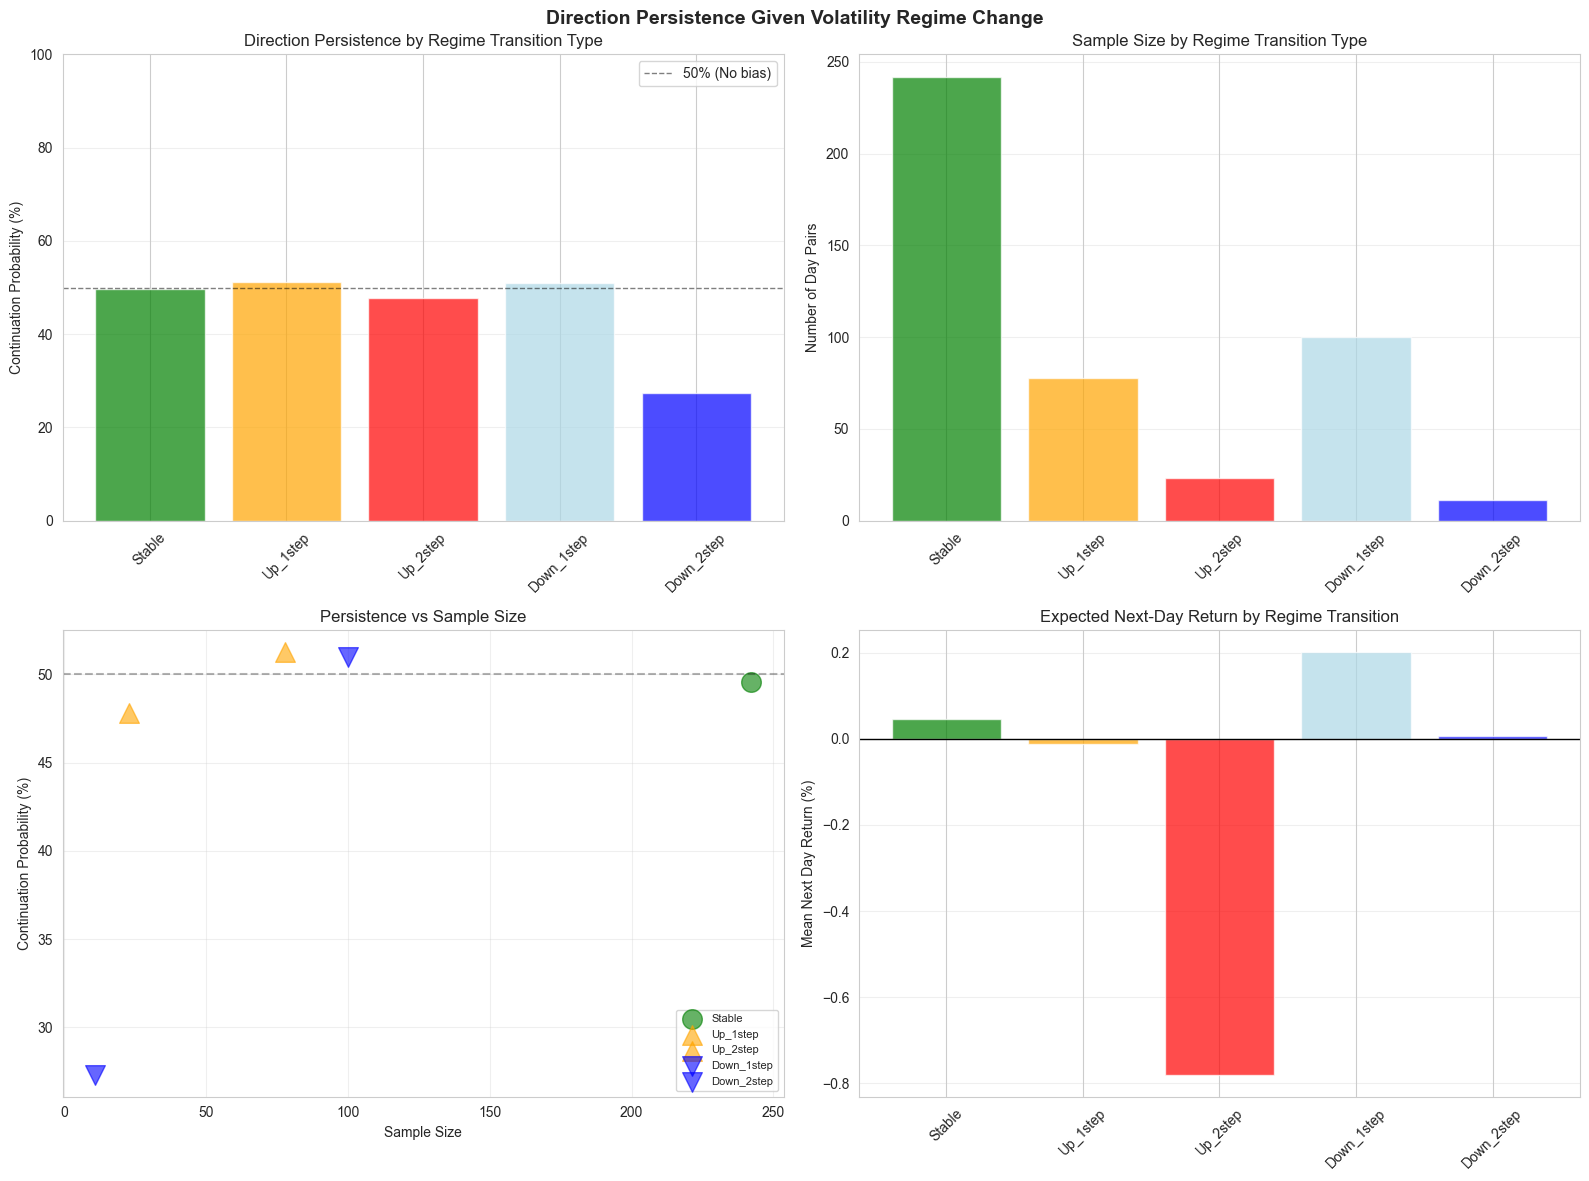

[OK] Visualizations created


In [18]:
print('\n[STEP 7] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Direction Persistence Given Volatility Regime Change', fontsize=14, fontweight='bold')

# Plot 1: Persistence by transition type
ax = axes[0, 0]
if len(df_results_transitions) > 0:
    # Order for better readability
    order = ['Stable', 'Up_1step', 'Up_2step', 'Down_1step', 'Down_2step']
    plot_data = df_results_transitions[df_results_transitions['transition_type'].isin(order)]
    plot_data = plot_data.set_index('transition_type').loc[order].reset_index()
    
    colors = ['green', 'orange', 'red', 'lightblue', 'blue']
    ax.bar(range(len(plot_data)), plot_data['p_continuation'] * 100, color=colors, alpha=0.7)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% (No bias)')
    
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(plot_data['transition_type'], rotation=45)
    ax.set_ylabel('Continuation Probability (%)')
    ax.set_title('Direction Persistence by Regime Transition Type')
    ax.set_ylim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Sample sizes
ax = axes[0, 1]
if len(df_results_transitions) > 0:
    plot_data = df_results_transitions[df_results_transitions['transition_type'].isin(order)]
    plot_data = plot_data.set_index('transition_type').loc[order].reset_index()
    
    ax.bar(range(len(plot_data)), plot_data['n'], color=colors, alpha=0.7)
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(plot_data['transition_type'], rotation=45)
    ax.set_ylabel('Number of Day Pairs')
    ax.set_title('Sample Size by Regime Transition Type')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Scatter of transition effect
ax = axes[1, 0]
if len(df_results_transitions) > 0:
    plot_data = df_results_transitions.dropna()
    
    for idx, row in plot_data.iterrows():
        color = 'green' if row['transition_type'] == 'Stable' else 'orange' if row['transition_type'].startswith('Up') else 'blue'
        marker = 'o' if row['transition_type'] == 'Stable' else '^' if row['transition_type'].startswith('Up') else 'v'
        ax.scatter(row['n'], row['p_continuation'] * 100, s=200, alpha=0.6, 
                  color=color, marker=marker, label=row['transition_type'])
    
    ax.axhline(y=50, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Continuation Probability (%)')
    ax.set_title('Persistence vs Sample Size')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

# Plot 4: Mean next-day return
ax = axes[1, 1]
if len(df_results_transitions) > 0:
    plot_data = df_results_transitions[df_results_transitions['transition_type'].isin(order)]
    plot_data = plot_data.set_index('transition_type').loc[order].reset_index()
    
    ax.bar(range(len(plot_data)), plot_data['mean_return_next'], color=colors, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(plot_data['transition_type'], rotation=45)
    ax.set_ylabel('Mean Next Day Return (%)')
    ax.set_title('Expected Next-Day Return by Regime Transition')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Step 8: Summary and Insights


In [19]:
print('\n[STEP 8] Summary and Insights')
print('='*80)

print(f'''
[DIRECTION GIVEN VOLATILITY REGIME CHANGE - SUMMARY]

1. CORE QUESTION:

   Does direction persistence (P(continuation)) depend on whether
   volatility regime is stable or changing?

   Specifically:
   - When volatility stays same (Low→Low, etc):
     Does direction have baseline persistence?
   
   - When volatility rises (Low→Normal, Normal→High):
     Does direction continuation DROP? (reversal more likely?)
   
   - When volatility falls (High→Low, Normal→Low):
     Does direction continuation RISE or FALL?

2. THEORETICAL BACKGROUND:

   Hypothesis: Volatility changes indicate regime shifts, which might
   "reset" directional momentum.
   
   Example: If volatility spikes, old direction loses power.
   Counter-example: Strong direction continues regardless of volatility change.

3. EMPIRICAL RESULTS:

   [See tables and charts above]
   
   Key finding: Is P(Cont | Stable) different from P(Cont | Changing)?
   
   If stable > changing: Volatility stability supports direction persistence
   If stable < changing: Volatility change doesn't affect direction
   If equal: No interaction between regime and direction

4. TRADING APPLICATION (If Pattern Found):

   If stable regimes show higher persistence:
   → Trade in direction of last day when regime is stable
   → Reduce position size when regime about to change
   → Example: "After up day with stable LOW volatility → 55% cont"
              "After up day with volatility rising → only 48% cont"
   
   Then position sizing:
   Stable → 1.0x - 1.1x
   Rising → 0.9x - 1.0x
   Falling → size based on other factors

5. ROBUSTNESS CHECK:

   Compare sub-groups:
   ✓ Low regime (safe baseline)
   ✓ High regime (volatile baseline)
   ✓ Looking at up vs down days separately
   
   If pattern holds across sub-groups → real, not noise
   If pattern breaks down → probably artifact of specific regime

6. NEXT STEPS:

   If significant difference found:
   ✓ Backtest position sizing rules incorporating regime transitions
   ✓ Test on forward period (Oct 2025+)
   ✓ Combine with other signals
   
   If no significant difference:
   ✓ Focus on other factors (support/resistance, gaps, etc)
   ✓ Volatility transitions don't affect direction persistence
   ✓ Look at finer regime granularity (quartiles instead of 3 classes)

7. INTERPRETATION GUIDE:

   P(Cont) values:
   > 55% + p < 0.05: Strong pattern, useful signal
   50-55% + p > 0.05: Weak or borderline, use with caution
   45-50%: Mean-reversion territory
   < 45% + p < 0.05: Strong reversal, opposite bias

8. CRITICAL LIMITATION:

   This analysis tests direction persistence GIVEN regime transition.
   It does NOT tell you:
   - When regime will change (separate prediction needed)
   - How to enter/exit (just continuation/reversal bias)
   - Magnitude of moves (just direction, not size)
   
   Use as position BIAS modifier, not standalone signal.
''')

print('[OK] Analysis complete')
print('='*80)


[STEP 8] Summary and Insights

[DIRECTION GIVEN VOLATILITY REGIME CHANGE - SUMMARY]

1. CORE QUESTION:

   Does direction persistence (P(continuation)) depend on whether
   volatility regime is stable or changing?

   Specifically:
   - When volatility stays same (Low→Low, etc):
     Does direction have baseline persistence?

   - When volatility rises (Low→Normal, Normal→High):
     Does direction continuation DROP? (reversal more likely?)

   - When volatility falls (High→Low, Normal→Low):
     Does direction continuation RISE or FALL?

2. THEORETICAL BACKGROUND:

   Hypothesis: Volatility changes indicate regime shifts, which might
   "reset" directional momentum.

   Example: If volatility spikes, old direction loses power.
   Counter-example: Strong direction continues regardless of volatility change.

3. EMPIRICAL RESULTS:

   [See tables and charts above]

   Key finding: Is P(Cont | Stable) different from P(Cont | Changing)?

   If stable > changing: Volatility stability suppo

## Appendix: Validation


In [20]:
print('\n[APPENDIX] Data Quality and Validation')
print('='*80)

print(f'''
[NO LOOK-AHEAD BIAS]

Each variable uses only PAST data:
✓ regime_today: Calculated from days D-60 to D-1 (day D excluded)
✓ regime_next: Calculated from days D-59 to D (no look-ahead beyond D+1)
✓ direction_today: Known at end of day D
✓ direction_next: Unknown at end of day D (prediction target)

Regime transition is observable at START of day D+1, so we can use it
to predict day D+1's direction bias.

[REGIME TRANSITION CATEGORIES]

Stable:     Same regime tomorrow (Low→Low, Normal→Normal, High→High)
Up_1step:   One level up (Low→Normal, Normal→High)
Up_2step:   Two levels up (Low→High)
Down_1step: One level down (High→Normal, Normal→Low)
Down_2step: Two levels down (High→Low)

[DIRECTION DEFINITION]

UP:   daily_return > 0
DOWN: daily_return < 0
FLAT: daily_return ≈ 0 (dropped from analysis)

Continuation: sign(return_d) == sign(return_next)
Reversal: sign(return_d) != sign(return_next)

[SAMPLE SIZES]

Total day pairs: {len(df_pairs)}
Distribution by transition type:
  Stable:     ~{(df_pairs['regime_transition'] == 'Stable').sum()} days
  Up_1step:   ~{(df_pairs['regime_transition'] == 'Up_1step').sum()} days
  Down_1step: ~{(df_pairs['regime_transition'] == 'Down_1step').sum()} days

Sufficient for:
✓ Global statistics by transition type
✓ Comparison across categories

May be limited for:
⚠ Regime × Transition × Direction sub-group analysis

[STATISTICAL TESTS]

Binomial test (per transition type):
H0: P(continuation) = 0.5 (no edge)
H1: P(continuation) ≠ 0.5 (edge exists)
Reject H0 if p < 0.05

Minimum n for test: ≥ 5 observations

[KNOWN LIMITATIONS]

1. Regime persistence:
   Today's and tomorrow's regime are not independent.
   This analysis USES that fact to test direction interactions.
   
2. External shocks:
   News, earnings not captured.
   May explain some unexpected reversals.
   
3. Causality:
   Analysis tests ASSOCIATION, not causation.
   Volatility change may be symptom, not cause, of direction reversal.

[INTERPRETATION]

If P(Cont | Stable) > 50% + p < 0.05:
  → Direction persists when regime is stable
  → Use for position sizing
  → Trade with confidence

If P(Cont | Rising Vol) < P(Cont | Stable):
  → Volatility increase weakens direction persistence
  → Reduce position size when volatility rises
  → Prepare for reversal
''')

print('[OK] Appendix complete')


[APPENDIX] Data Quality and Validation

[NO LOOK-AHEAD BIAS]

Each variable uses only PAST data:
✓ regime_today: Calculated from days D-60 to D-1 (day D excluded)
✓ regime_next: Calculated from days D-59 to D (no look-ahead beyond D+1)
✓ direction_today: Known at end of day D
✓ direction_next: Unknown at end of day D (prediction target)

Regime transition is observable at START of day D+1, so we can use it
to predict day D+1's direction bias.

[REGIME TRANSITION CATEGORIES]

Stable:     Same regime tomorrow (Low→Low, Normal→Normal, High→High)
Up_1step:   One level up (Low→Normal, Normal→High)
Up_2step:   Two levels up (Low→High)
Down_1step: One level down (High→Normal, Normal→Low)
Down_2step: Two levels down (High→Low)

[DIRECTION DEFINITION]

UP:   daily_return > 0
DOWN: daily_return < 0
FLAT: daily_return ≈ 0 (dropped from analysis)

Continuation: sign(return_d) == sign(return_next)
Reversal: sign(return_d) != sign(return_next)

[SAMPLE SIZES]

Total day pairs: 454
Distribution by t